In [347]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE

pd.options.display.float_format = '{:,.4f}'.format
POWER=2
QUANTILE=0.999
plt.style.use('ggplot')

In [348]:
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('seaborn',sns.__version__)
import sklearn as skl
print('sklearn', skl.__version__)
import matplotlib as mp
print('matplotlib', mp.__version__)

pandas 1.3.2
numpy 1.21.2
seaborn 0.11.2
sklearn 1.0.1
matplotlib 3.4.3


## Functions

In [349]:
## Functions
def print_results(modelin, Xin, yin, X_testin, y_testin, show=1):
    _y_pred = modelin.predict(Xin)
    _y_test_pred = modelin.predict(X_testin)
    trn = [r2_score(yin, _y_pred), mean_squared_error(yin, _y_pred), 
           mean_absolute_error(yin, _y_pred)]
    tst = [r2_score(y_testin, _y_test_pred), mean_squared_error(y_testin, _y_test_pred), 
           mean_absolute_error(y_testin, _y_test_pred)]
    if show == 1:
        print("Train r2_score".ljust(15), r2_score(yin, _y_pred))
        print("Test r2_score".ljust(15), r2_score(y_testin, _y_test_pred))
    return trn, tst, _y_pred, _y_test_pred

def get_gridcv_results(mdl):
    res = pd.DataFrame.from_dict(mdl.cv_results_)
    to_drop = []
    for col in res.columns:
        if col.endswith('_time'):
            to_drop.append(col)
    res = res.drop(to_drop, axis=1)
    res['diff'] = (res['mean_train_score'] - res['mean_test_score']) * 100
    res = res.set_index('param_alpha')
    res = res.transpose()
    return res


## Initial Data Inspection

In [350]:
df = pd.read_csv("./train.csv", low_memory=False)
df.shape

(1460, 81)

In [351]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [352]:
df.head(15)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0000,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0000,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0000,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0000,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [353]:
# for col in list(df.columns):
#     if df[col].isnull().sum() > 0:
#         print(col, df[col].isnull().sum(), 100 * df[col].isnull().sum()/df.shape[0], df[col].unique())

### Columns where all values are same

In [354]:
same_columns = {}
for c in df.columns:
    if df[c].value_counts().shape[0] == 1:
        same_columns[c] = list(df[c].unique())
same_columns

{}

In [355]:
dfnans = pd.DataFrame()
dfnans['counts'] = df[df.columns[df.isnull().any()]].isnull().sum()
dfnans['perc'] = 100 * dfnans['counts'] / df.shape[0]
dfnans = dfnans.reset_index()
dfnans['uniq_counts'] = dfnans['index'].apply(lambda x: len(df[x].unique()))
dfnans['dtype'] = dfnans['index'].apply(lambda x: df[x].dtype)
dfnans

,index,counts,perc,uniq_counts,dtype
0,LotFrontage,259,17.7397,111,float64
1,Alley,1369,93.7671,3,object
2,MasVnrType,8,0.5479,5,object
3,MasVnrArea,8,0.5479,328,float64
4,BsmtQual,37,2.5342,5,object
5,BsmtCond,37,2.5342,5,object
6,BsmtExposure,38,2.6027,5,object
7,BsmtFinType1,37,2.5342,7,object
8,BsmtFinType2,38,2.6027,7,object
9,Electrical,1,0.0685,6,object


### Columns with more than 40% nans

In [356]:
too_many_nans = df[df.columns[df.isnull().sum() * 100 / df.shape[0] > 40]].columns.tolist()
too_many_nans

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [357]:
df = df.drop(too_many_nans, axis=1)
df.shape

(1460, 76)

### Drop columns with very few nans

In [358]:
df = df[df['Electrical'].notna()]
df = df[df['MasVnrType'].notna()]
df.shape

(1451, 76)

In [359]:
dfnans = pd.DataFrame()
dfnans['counts'] = df[df.columns[df.isnull().any()]].isnull().sum()
dfnans['perc'] = 100 * dfnans['counts'] / df.shape[0]
dfnans = dfnans.reset_index()
dfnans['uniq_counts'] = dfnans['index'].apply(lambda x: len(df[x].unique()))
dfnans['dtype'] = dfnans['index'].apply(lambda x: df[x].dtype)
dfnans

,index,counts,perc,uniq_counts,dtype
0,LotFrontage,257,17.7119,111,float64
1,BsmtQual,37,2.5500,5,object
2,BsmtCond,37,2.5500,5,object
3,BsmtExposure,38,2.6189,5,object
4,BsmtFinType1,37,2.5500,7,object
5,BsmtFinType2,38,2.6189,7,object
6,GarageType,81,5.5824,7,object
7,GarageYrBlt,81,5.5824,98,float64
8,GarageFinish,81,5.5824,4,object
9,GarageQual,81,5.5824,6,object


### Insert GarageYrBlt nans with YearBuilt

In [360]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

### Inspect lot frontage

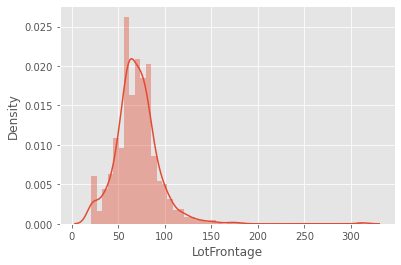

In [361]:
sns.distplot(df['LotFrontage'], hist=True)
plt.show()

LotFrontage is skewed. We will use mode to impute

### Impute nan with mode

In [362]:
for col in list(dfnans['index']):
    if col == 'GarageYrBlt':
        continue
    df[col] = df[col].fillna(df[col].mode(dropna=True)[0])
    print(col, df[col].mode(dropna=True)[0])

LotFrontage 60.0
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFinType1 Unf
BsmtFinType2 Unf
GarageType Attchd
GarageFinish Unf
GarageQual TA
GarageCond TA


In [363]:
df[df.columns[df.isnull().any()]].isnull().sum()

Series([], dtype: float64)

#### This finishes dealing with missing values

### EDA

In [364]:
categoricals = []
ints = []
floats = []
numericals = []
for col in df.columns:
    if df[col].dtype == np.int64:
        ints.append(col)
        numericals.append(col)
    elif df[col].dtype == np.float64:
        floats.append(col)
        numericals.append(col)
    else:
        categoricals.append(col)

In [365]:
# n_cols = 3
# plt.figure(figsize=(24, 48))
# for i, col in enumerate(categoricals):    
#     g = df.groupby([col]).mean()
#     plt.subplot(10, 4, i+1)
#     sns.barplot(data=g, x=g.index, y=100 * g['SalePrice'] / g['SalePrice'].sum())
# plt.show()

### Bar plot
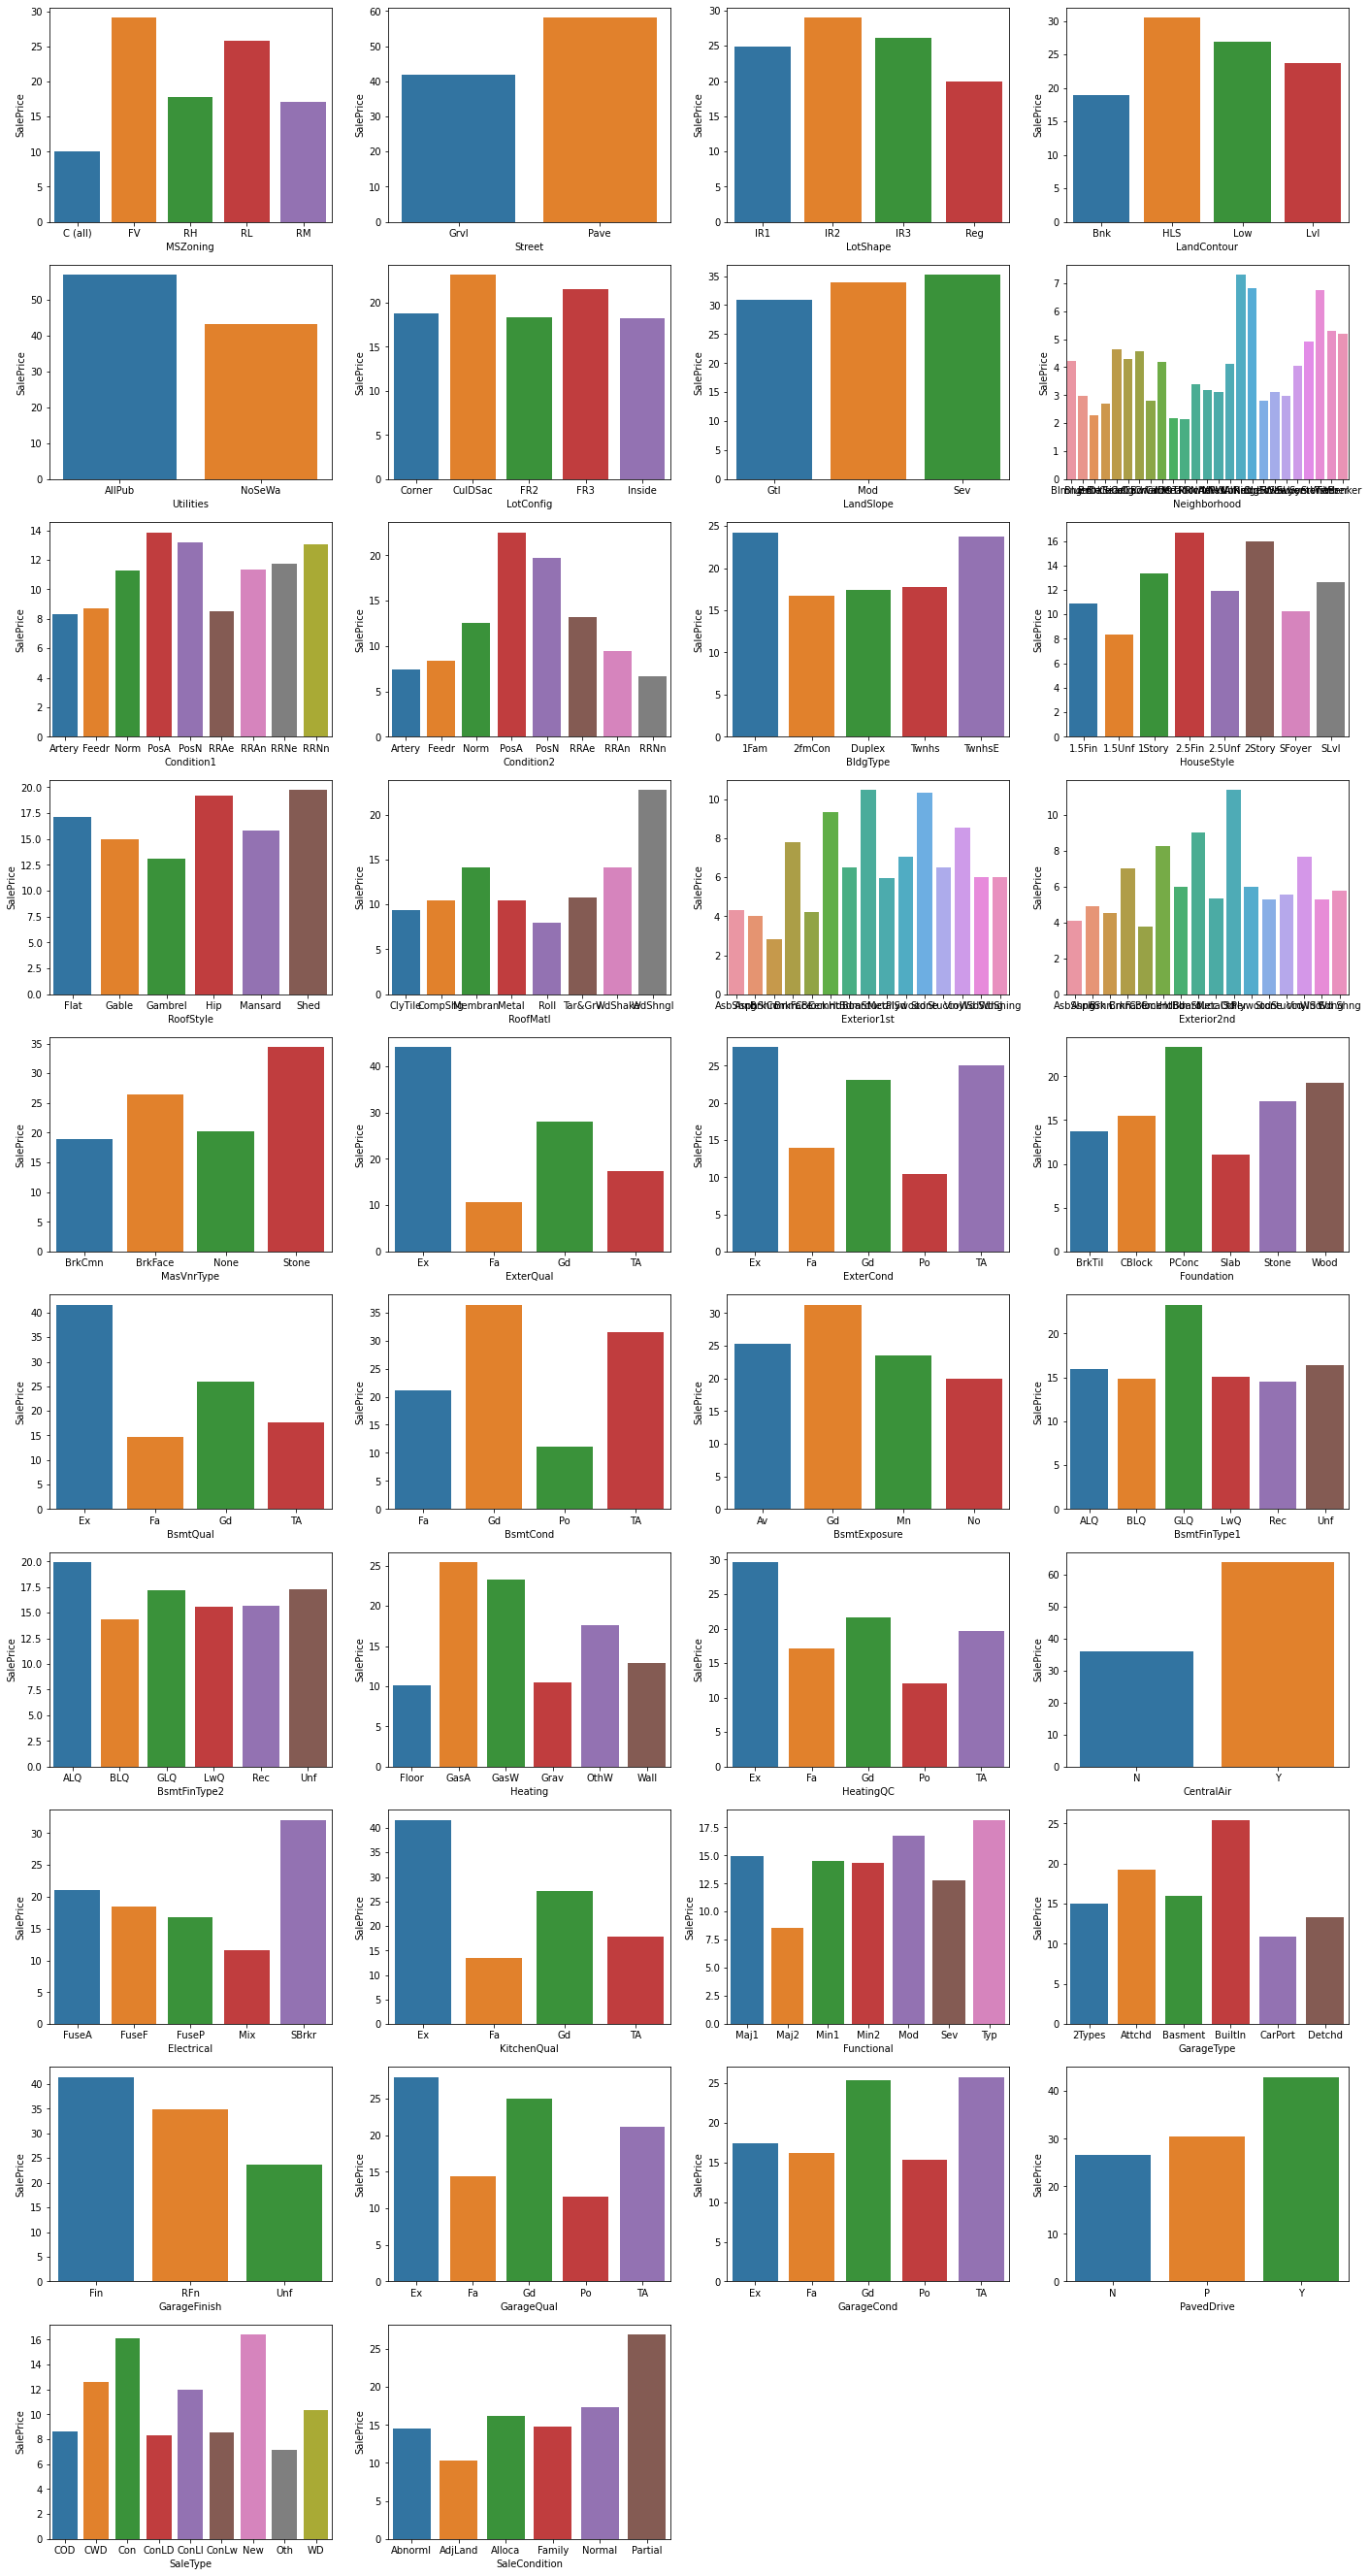

### Observations
- Almost all variables seem to have some impact of SalePrice
- Since number of variables is very high, we will keep all and rely on Lasso and Rfe to deal with unnecessary variables

In [366]:
drop_cols = categoricals
dfhm = df.drop(drop_cols, axis=1)
dfcorr = dfhm.corr()

In [367]:
# plt.figure(figsize=(24, 21))
# sns.heatmap(dfcorr*100, 
#             xticklabels = dfcorr.columns.values,
#             yticklabels = dfcorr.columns.values,
#             vmin = -100.0, vmax = 100.0, fmt='.0f',
#             annot = True, cmap="RdYlGn");
# plt.show()

### Correlation plot
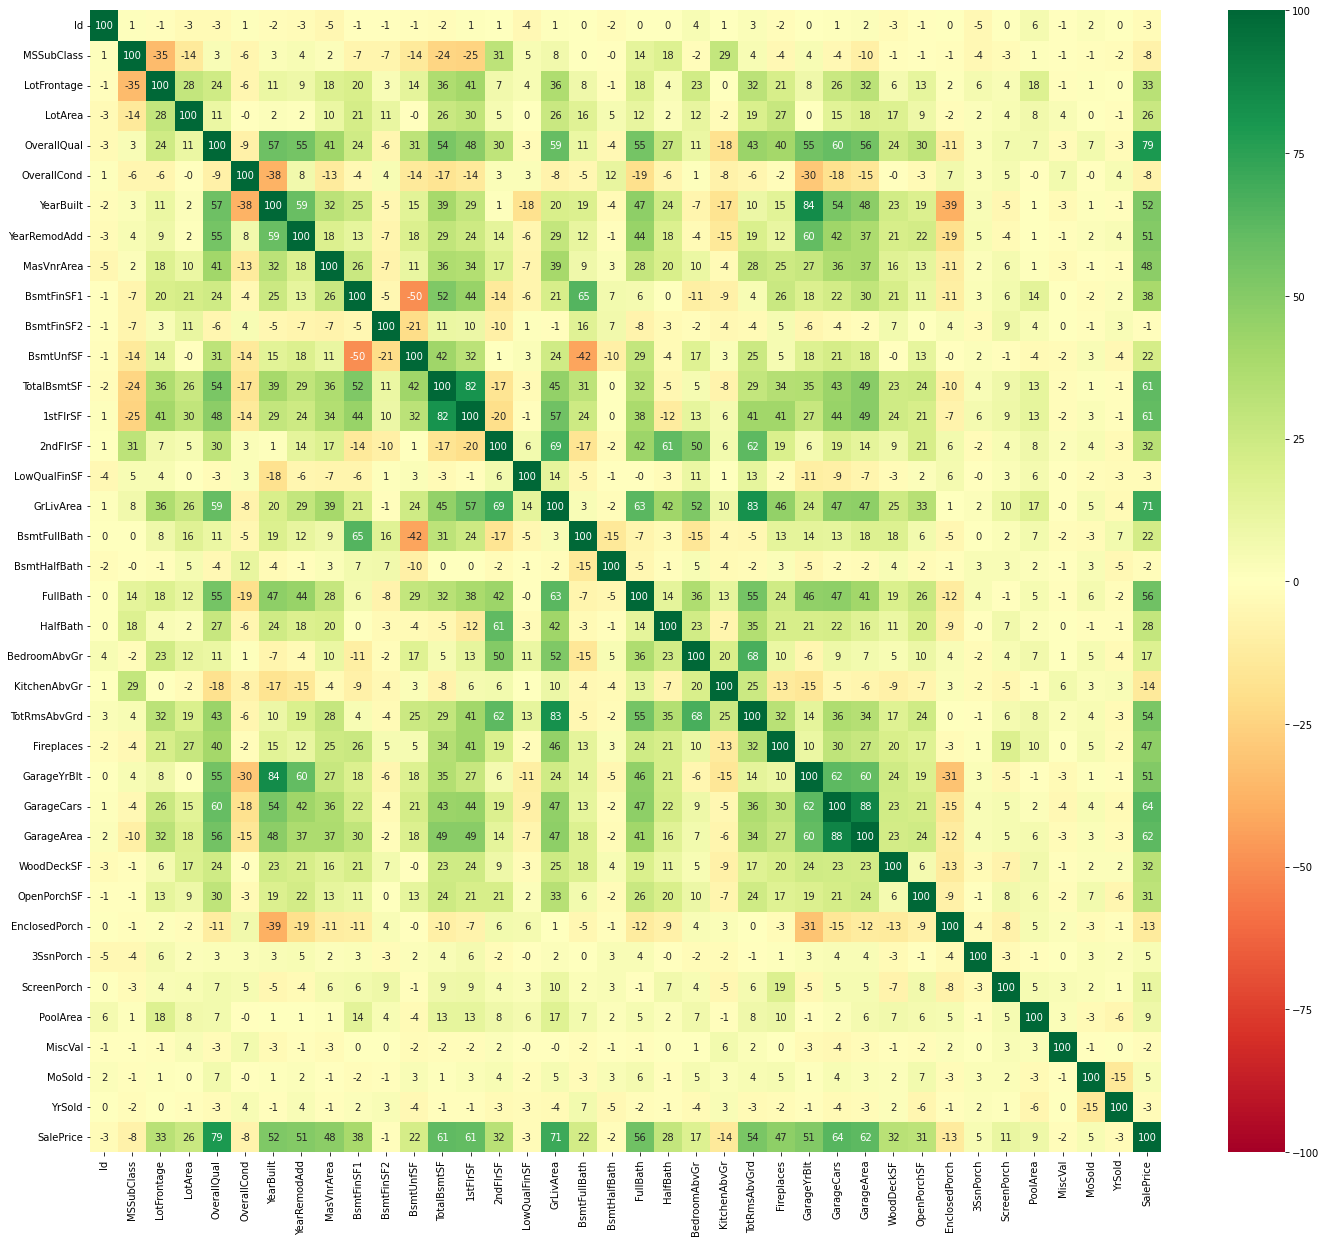

There are some features which have correlation, but we will rely on Ridge and Lasso to deal with these.

In [368]:
df.shape

(1451, 76)

In [369]:
print(len(numericals), len(categoricals), df.shape)

38 38 (1451, 76)


#### Derived Variables: Create Age from year colums

In [370]:
df['Age'] = 2022 - df['YearBuilt']
df['RemodAge'] = 2022 - df['YearRemodAdd']
df['GarageAge'] = 2022 - df['GarageYrBlt']

In [371]:
print(len(numericals), len(categoricals), df.shape)

38 38 (1451, 79)


### Drop year columns

In [372]:
print(df.shape)
to_drop = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'Id']
df = df.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'Id'], axis=1)
numericals = list(set(numericals) - set(to_drop))
numericals.extend(['Age', 'RemodAge', 'GarageAge'])
print(len(numericals), len(categoricals), len(numericals) + len(categoricals), df.shape)

(1451, 79)
36 38 74 (1451, 74)


### Inspect Target Variable

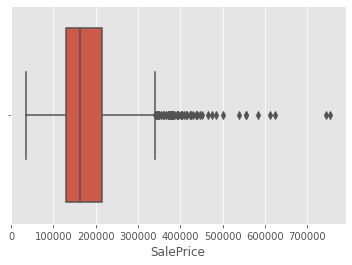

In [373]:
df['SalePrice'].describe()
sns.boxplot(df['SalePrice'])
plt.show()

In [374]:
df['SalePrice'] = np.log(df['SalePrice'])
df['SalePrice'].describe()

count   1,451.0000
mean       12.0224
std         0.3995
min        10.4602
25%        11.7745
50%        11.9984
75%        12.2737
max        13.5345
Name: SalePrice, dtype: float64

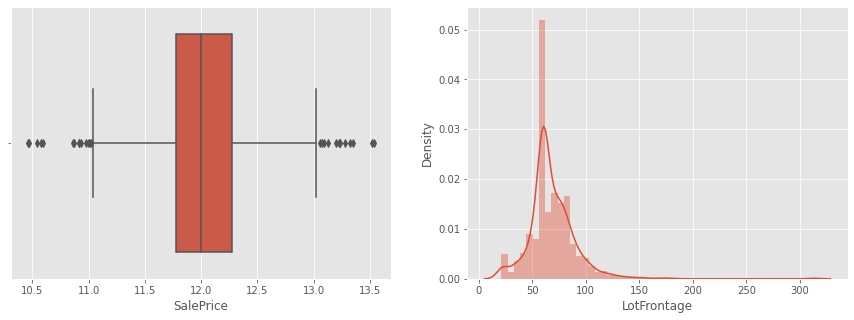

In [375]:

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(df['SalePrice'])
plt.subplot(1, 2, 2)
sns.distplot(df['LotFrontage'], hist=True)
plt.show()

In [376]:
# dfplot1 = df.drop(categoricals, axis=1)
# sns.pairplot(dfplot1)
# plt.show()
drop_cols = categoricals
dfhm = df.drop(drop_cols, axis=1)
dfcorr = dfhm.corr()
dfcorr.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'SalePrice', 'Age', 'RemodAge', 'GarageAge'],
      dtype='object')

In [377]:
to_plot = []
for col in dfcorr.columns:
    if abs(dfcorr.loc['SalePrice', col]) > 0.5:
        to_plot.append(col)
to_plot

['OverallQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'SalePrice',
 'Age',
 'RemodAge',
 'GarageAge']

In [378]:
dfplot1 = df.filter(to_plot, axis=1)
# sns.pairplot(dfplot1)
# plt.show()

## Pair Plot

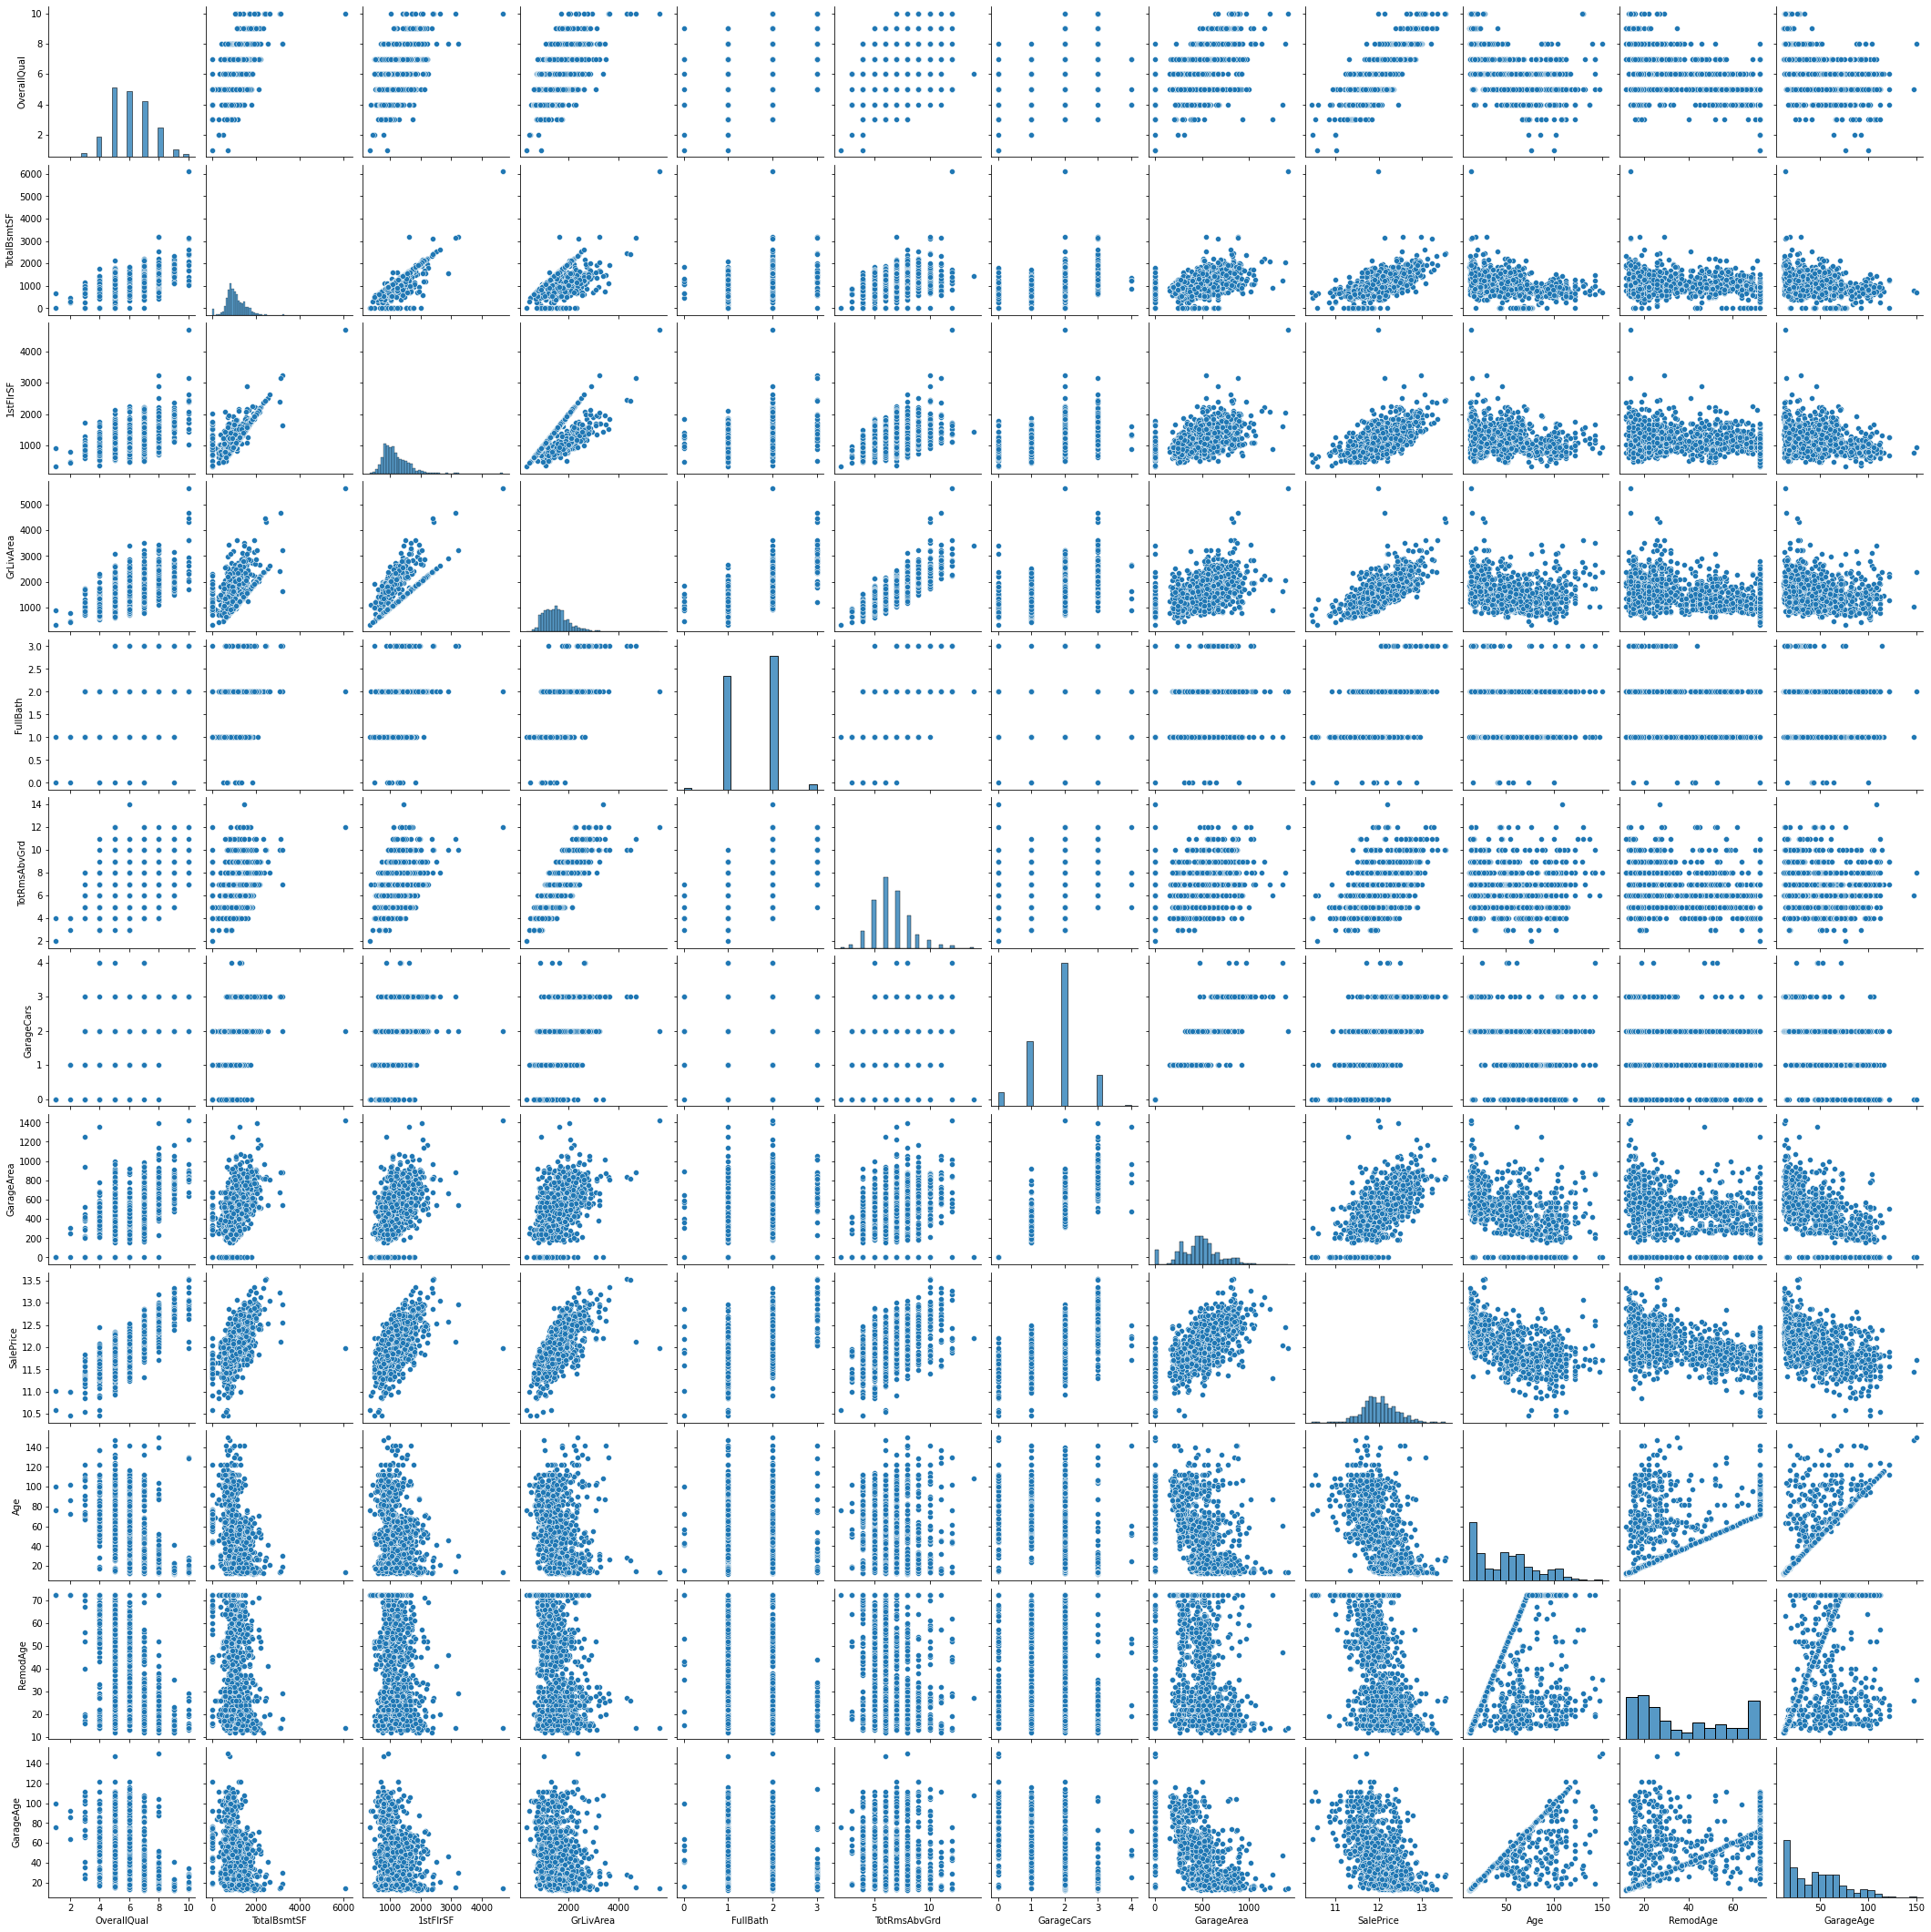

In [379]:
dfplot1 = dfplot1.drop(['Age', 'RemodAge', 'GarageAge', 'GarageCars', 'FullBath', ],axis=1)

In [380]:
len(numericals)

36

### Check outliers in the columns with largest correlation

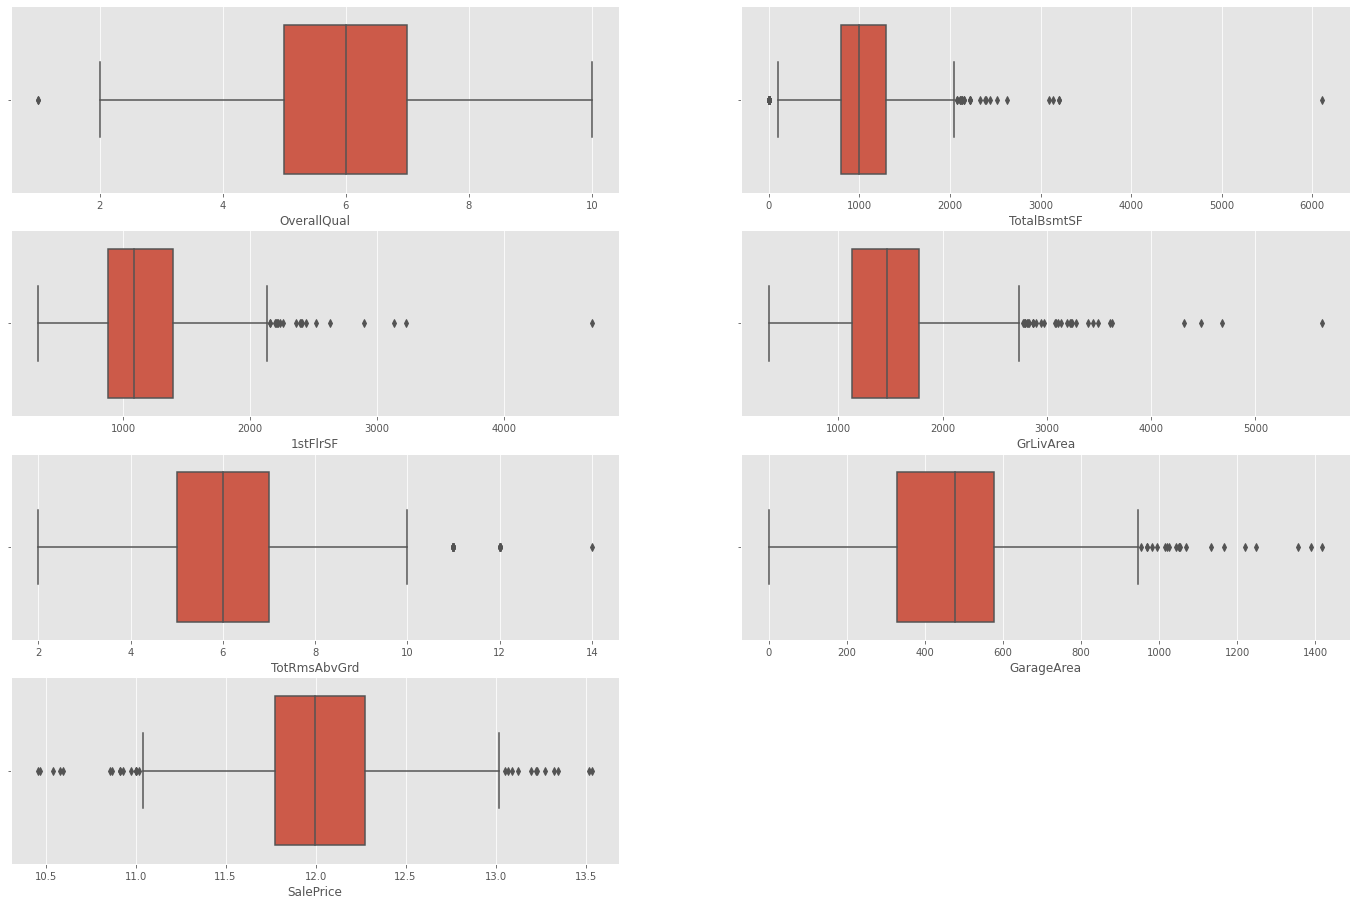

In [381]:
plt.figure(figsize=(24, 24))
for i, col in enumerate(dfplot1.columns):    
    plt.subplot(6, 2, i+1)
    sns.boxplot(dfplot1[col])
plt.show()

### Check and remove outliers
Only the extreme outliers are removed here because data available is very little.

In [382]:
print(df.shape)
for i, col in enumerate(dfplot1.columns): 
    q = QUANTILE
    if col == 'SalePrice':
        q = 0.99
    print(col, df.loc[df[col] > df[col].quantile(q)][col].count(), df.shape)
    df = df.loc[df[col] <= df[col].quantile(q)]

(1451, 74)
OverallQual 0 (1451, 74)
TotalBsmtSF 2 (1451, 74)
1stFlrSF 2 (1449, 74)
GrLivArea 2 (1447, 74)
TotRmsAbvGrd 1 (1445, 74)
GarageArea 2 (1444, 74)
SalePrice 15 (1442, 74)


### Encode Categoricals

In [383]:
to_onehot = categoricals
df1 = pd.get_dummies(df, columns=to_onehot, prefix=to_onehot, drop_first=True)
print(df1.shape)
print(df1.columns)

(1427, 231)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=231)


In [384]:
df1['SalePrice'].describe(percentiles=[.05, .10, .25, .5, .75, .9, .95])

count   1,427.0000
mean       12.0071
std         0.3806
min        10.4602
5%         11.3851
10%        11.5712
25%        11.7695
50%        11.9829
75%        12.2572
90%        12.5136
95%        12.6663
max        12.9622
Name: SalePrice, dtype: float64

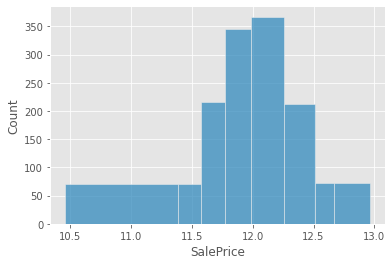

In [385]:
sns.histplot(data=df1, x="SalePrice", bins=df1['SalePrice'].quantile([0, .05, .10, .25, .5, .75, .9, .95, 1]))
plt.show()

## SalePrice is skewed. We will use stratified sampling to create test/train sets
Create a dummy feature ystrat to use for stratified sampling

In [386]:
ystrat = pd.qcut(df1['SalePrice'], [0, .05, .10, .25, .5, .75, .9, .95, 1], 
                 labels=[1, 2, 3, 4, 5, 6, 7, 8])
ystrat.value_counts()

4    357
5    356
6    215
3    212
1     75
8     72
2     70
7     70
Name: SalePrice, dtype: int64

In [387]:
y = df1.pop('SalePrice')
X = df1

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=ystrat)
print(X_train.shape, X_test.shape)

numerical_feats = numericals.copy()
numerical_feats.remove('SalePrice')

scaler = RobustScaler()
scaler.fit(X_train[numerical_feats])
X_train[numerical_feats] = scaler.transform(X_train[numerical_feats])
X_test[numerical_feats] = scaler.transform(X_test[numerical_feats])

(1141, 230) (286, 230)


### Fit Linear regression model

In [389]:
lm = LinearRegression()
lm.fit(X_train,y_train)
r2_train, r2_test, y_pred, y_test_pred = print_results(lm, X_train, y_train, X_test, y_test, 0)
print(f'R2 train: {r2_train}, R2 test: {r2_test}')

R2 train: [0.9523386353989224, 0.0069938760618862335, 0.06118084141022718], R2 test: [0.8415094640706992, 0.021665210137371042, 0.09195252958912778]


### Try lasso and ridge

#### Find best value for Lasso

In [390]:
lalphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, .1, 1, 10]
for alpha in lalphas:
    lsm = Lasso(alpha=alpha)
    lsm.fit(X_train, y_train)
    r2_trn, r2_tst, y_pred, y_test_pred = print_results(lsm, X_train, y_train, X_test, y_test, 0)
    print(f'Alpha: {alpha:.8f}, R2 train: {r2_trn[0]:.4f}, R2 test: {r2_tst[0]:.4f}, Zeros: {list(lsm.coef_).count(0.)}')

Alpha: 0.00000100, R2 train: 0.9523, R2 test: 0.8421, Zeros: 3
Alpha: 0.00001000, R2 train: 0.9522, R2 test: 0.8466, Zeros: 11
Alpha: 0.00010000, R2 train: 0.9486, R2 test: 0.8724, Zeros: 57
Alpha: 0.00100000, R2 train: 0.9237, R2 test: 0.9004, Zeros: 161
Alpha: 0.01000000, R2 train: 0.8889, R2 test: 0.8673, Zeros: 204
Alpha: 0.10000000, R2 train: 0.6313, R2 test: 0.6225, Zeros: 218
Alpha: 1.00000000, R2 train: 0.0236, R2 test: 0.0405, Zeros: 227
Alpha: 10.00000000, R2 train: 0.0000, R2 test: -0.0003, Zeros: 230


In [391]:
params = {'alpha': [0.0001, .0002, .0004, .0008, 0.001, 0.0012, .0015, .0018, 0.002, .0022, .0025, 0.005, .01]}
lmdl = GridSearchCV(Lasso(), param_grid=params, cv=5, scoring= 'r2',
                    return_train_score=True, verbose=2)
lmdl.fit(X, y)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .......................................alpha=0.0002; total time=   0.0s
[CV] END .......................................alpha=0.0002; total time=   0.1s
[CV] END .......................................alpha=0.0002; total time=   0.0s
[CV] END .......................................alpha=0.0002; total time=   0.0s
[CV] END .......................................alpha=0.0002; total time=   0.0s
[CV] END .......................................alpha=0.0004; total time=   0.0s
[CV] END .......................................

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0004, 0.0008, 0.001,
                                   0.0012, 0.0015, 0.0018, 0.002, 0.0022,
                                   0.0025, 0.005, 0.01]},
             return_train_score=True, scoring='r2', verbose=2)

In [392]:
get_gridcv_results(lmdl)

param_alpha,0.0001,0.0002,0.0004,0.0008,0.0010,0.0012,0.0015,0.0018,0.0020,0.0022,0.0025,0.0050,0.0100
params,{'alpha': 0.0001},{'alpha': 0.0002},{'alpha': 0.0004},{'alpha': 0.0008},{'alpha': 0.001},{'alpha': 0.0012},{'alpha': 0.0015},{'alpha': 0.0018},{'alpha': 0.002},{'alpha': 0.0022},{'alpha': 0.0025},{'alpha': 0.005},{'alpha': 0.01}
split0_test_score,0.9152,0.9170,0.9126,0.9112,0.9096,0.9080,0.9057,0.9028,0.9007,0.8985,0.8956,0.8841,0.8797
split1_test_score,0.9047,0.9106,0.9111,0.9103,0.9087,0.9074,0.9056,0.9041,0.9032,0.9023,0.9009,0.8937,0.8901
split2_test_score,0.8909,0.8933,0.8971,0.8963,0.8952,0.8944,0.8923,0.8895,0.8877,0.8857,0.8830,0.8747,0.8725
split3_test_score,0.9200,0.9210,0.9181,0.9163,0.9162,0.9156,0.9146,0.9130,0.9117,0.9104,0.9093,0.8966,0.8887
split4_test_score,0.8995,0.9032,0.9059,0.9049,0.9038,0.9023,0.9002,0.8973,0.8950,0.8928,0.8900,0.8754,0.8679
mean_test_score,0.9061,0.9090,0.9089,0.9078,0.9067,0.9055,0.9037,0.9013,0.8997,0.8979,0.8958,0.8849,0.8798
std_test_score,0.0105,0.0099,0.0071,0.0068,0.0070,0.0070,0.0073,0.0078,0.0081,0.0084,0.0090,0.0090,0.0087
rank_test_score,5,1,2,3,4,6,7,8,9,10,11,12,13
split0_train_score,0.9406,0.9365,0.9299,0.9226,0.9203,0.9183,0.9157,0.9130,0.9111,0.9092,0.9066,0.8949,0.8881


#### Find best value for Ridge

In [393]:
alphas = [0.01, .1, 1, 10, 20, 30, 40, 50, 75, 100]
for alpha in alphas:
    rm = Ridge(alpha=alpha)
    rm.fit(X_train, y_train)
    r2_trn, r2_tst, y_pred, y_test_pred = print_results(rm, X_train, y_train, X_test, y_test, 0)
    print(f'Alpha: {alpha:.2f}, R2 train: {r2_trn[0]:.4f}, R2 test: {r2_tst[0]:.4f}', {list(rm.coef_).count(0.)})

Alpha: 0.01, R2 train: 0.9523, R2 test: 0.8434 {2}
Alpha: 0.10, R2 train: 0.9520, R2 test: 0.8546 {2}
Alpha: 1.00, R2 train: 0.9483, R2 test: 0.8840 {2}
Alpha: 10.00, R2 train: 0.9366, R2 test: 0.9027 {2}
Alpha: 20.00, R2 train: 0.9319, R2 test: 0.9035 {2}
Alpha: 30.00, R2 train: 0.9288, R2 test: 0.9029 {2}
Alpha: 40.00, R2 train: 0.9264, R2 test: 0.9020 {2}
Alpha: 50.00, R2 train: 0.9244, R2 test: 0.9010 {2}
Alpha: 75.00, R2 train: 0.9202, R2 test: 0.8984 {2}
Alpha: 100.00, R2 train: 0.9169, R2 test: 0.8960 {2}


In [394]:
params = {'alpha': [1, 2, 5, 8, 10, 12, 15, 18, 20, 22, 25]}
rmdl = GridSearchCV(Ridge(), param_grid=params, cv=5, scoring= 'r2',
                    return_train_score=True, verbose=2)
rmdl.fit(X, y)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=5; total time=   0.0s
[CV] END .......................................

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1, 2, 5, 8, 10, 12, 15, 18, 20, 22, 25]},
             return_train_score=True, scoring='r2', verbose=2)

In [395]:
get_gridcv_results(rmdl)

param_alpha,1,2,5,8,10,12,15,18,20,22,25
params,{'alpha': 1},{'alpha': 2},{'alpha': 5},{'alpha': 8},{'alpha': 10},{'alpha': 12},{'alpha': 15},{'alpha': 18},{'alpha': 20},{'alpha': 22},{'alpha': 25}
split0_test_score,0.9116,0.9128,0.9129,0.9125,0.9122,0.9119,0.9115,0.9110,0.9108,0.9105,0.9101
split1_test_score,0.9010,0.9043,0.9077,0.9088,0.9091,0.9093,0.9095,0.9095,0.9095,0.9095,0.9094
split2_test_score,0.8877,0.8930,0.8976,0.8987,0.8990,0.8990,0.8990,0.8987,0.8986,0.8984,0.8981
split3_test_score,0.9179,0.9193,0.9199,0.9198,0.9196,0.9194,0.9191,0.9188,0.9186,0.9184,0.9181
split4_test_score,0.9000,0.9016,0.9034,0.9041,0.9043,0.9045,0.9045,0.9044,0.9044,0.9043,0.9041
mean_test_score,0.9036,0.9062,0.9083,0.9088,0.9088,0.9088,0.9087,0.9085,0.9084,0.9082,0.9080
std_test_score,0.0104,0.0091,0.0077,0.0072,0.0070,0.0069,0.0068,0.0067,0.0067,0.0067,0.0067
rank_test_score,11,10,7,3,1,2,4,5,6,8,9
split0_train_score,0.9416,0.9396,0.9362,0.9341,0.9331,0.9321,0.9309,0.9298,0.9292,0.9286,0.9278


In [396]:
rmdl.best_params_

{'alpha': 10}

### Best Values
Best values are chosen by visual inspection instead of using model.best_params_.  
Value which had minimum std deviation for train, and less difference between test and train score was chosen.  
Ridge: 15  
Lasso: 0.001  

In [397]:
ridge_best = 15
lasso_best = 0.0010
# ridge_best = rmdl.best_params_['alpha']
# lasso_best = lmdl.best_params_['alpha']
print(f"Best Values: Ridge: {ridge_best}, Lasso: {lasso_best}")
ridge_mdl = Ridge(alpha=ridge_best)
ridge_mdl.fit(X_train, y_train)
lasso_mdl = Lasso(alpha=lasso_best)
lasso_mdl.fit(X_train, y_train)

r_r2_train, r_r2_test, r_pred, r_test_pred = print_results(ridge_mdl, X_train, y_train, X_test, y_test, 0)
ls_r2_train, ls_r2_test, ls_pred, ls_test_pred = print_results(lasso_mdl, X_train, y_train, X_test, y_test, 0)
print(f'Ridge: {r_r2_train}, {r_r2_test}')
print(f'Lasso: {ls_r2_train}, {ls_r2_test} {X_train.shape[1] - list(lasso_mdl.coef_).count(0.)}')

Best Values: Ridge: 15, Lasso: 0.001
Ridge: [0.9339534980743254, 0.00969172940505474, 0.06991020305878481], [0.9034179214490679, 0.013202498275628442, 0.07796446694127915]
Lasso: [0.9237029797633818, 0.011195900660680396, 0.07480510037140005], [0.9004395881263638, 0.013609628057335416, 0.07817952091528557] 69


In [398]:
def check_error_distribution(yin, yin_pred):
#     rres = yin - yin_pred
    rres = np.exp(yin) - np.exp(yin_pred)
    print(f"Mean of resuduals {abs(rres.mean()):.4f}")
    print(f"Stdev of resuduals {abs(rres.std()):.4f}")
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.distplot(rres)
    plt.subplot(1, 2, 2)
    scp = sns.scatterplot(np.exp(yin), rres)
    scp.axhline(0.0)
    plt.show()

Mean of resuduals 1290.1306
Stdev of resuduals 19951.5605


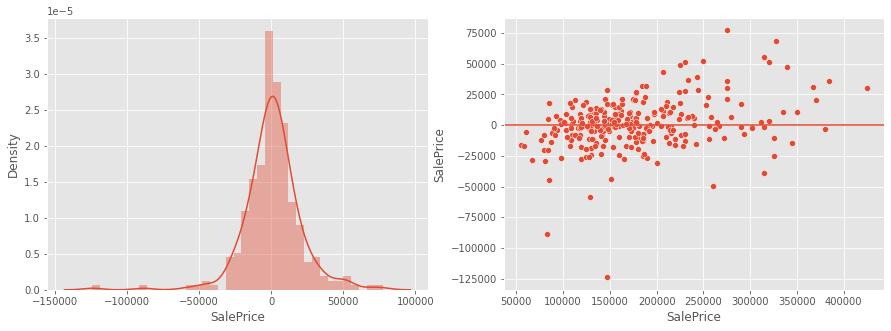

In [399]:
check_error_distribution(y_test, y_test_pred)

Mean of resuduals 249.8171
Stdev of resuduals 19459.8501


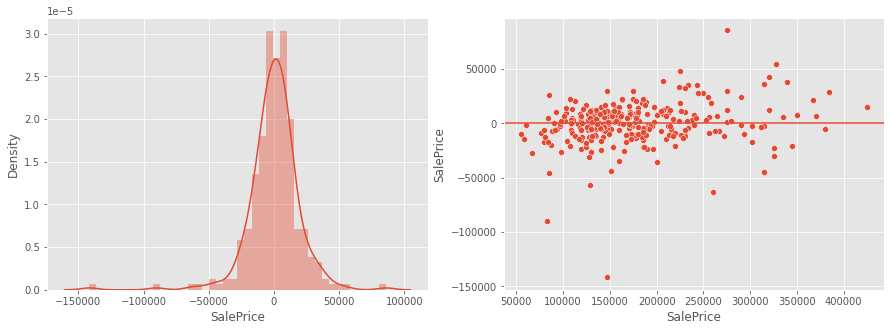

In [400]:
check_error_distribution(y_test, ls_test_pred)

Mean of resuduals 363.9104
Stdev of resuduals 19031.5068


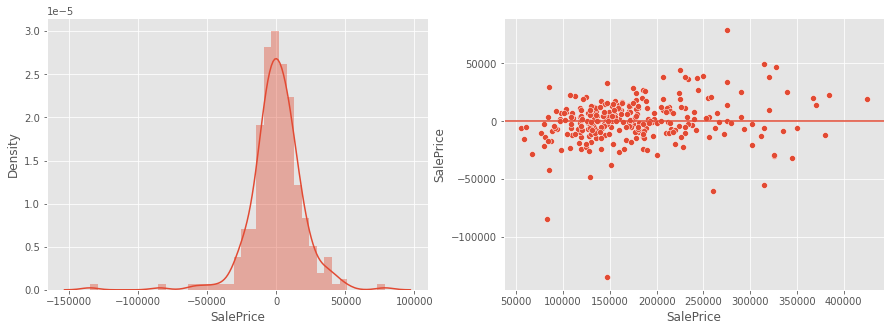

In [401]:
check_error_distribution(y_test, r_test_pred)

## Observations
Residual for all models:
- Seem to be normally distributed. 
- Mean of Lasso is closest to zero followed by Ridge.
- There are no patterns.
- Only 1-2 values are outliers.


In [402]:
def create_df_compare(labels, values):
    _compdf = pd.DataFrame(columns=['alpha', 'features', 'r2_train', 'mse_train', 'mae_train', 'r2_test', 
                                    'mse_test', 'mae_test'])
    for i,l in enumerate(labels):
        print(f"Label: {l}" )
        _compdf.loc[l] = values[i]
    _compdf = _compdf[['alpha', 'features', 'r2_train', 'r2_test', 'mse_train', 'mse_test', 
                       'mae_train', 'mae_test',]]
    _compdf['features'] = _compdf['features'].astype(np.int64)
    _compdf['mse_test_to_train'] = _compdf['mse_test'] / _compdf['mse_train']
    return _compdf

### Compare models

In [403]:
nfeats = X_train.shape[1]
nfeatsRidge = X_train.shape[1] - sum(1 for x in list(ridge_mdl.coef_) if abs(x) == 0.000)
nfeatsLasso = X_train.shape[1] - list(lasso_mdl.coef_).count(0.)
compdf = create_df_compare(['Linear', 'Ridge', 'Lasso'], 
                           [['-', nfeats] + r2_train + r2_test, 
                            [ridge_best, nfeatsRidge] + r_r2_train + r_r2_test, 
                            [lasso_best, nfeatsLasso] + ls_r2_train + ls_r2_test])
compdf

Label: Linear
Label: Ridge
Label: Lasso


,alpha,features,r2_train,r2_test,mse_train,mse_test,mae_train,mae_test,mse_test_to_train
Linear,-,230,0.9523,0.8415,0.0070,0.0217,0.0612,0.0920,3.0977
Ridge,15.0000,228,0.9340,0.9034,0.0097,0.0132,0.0699,0.0780,1.3622
Lasso,0.0010,69,0.9237,0.9004,0.0112,0.0136,0.0748,0.0782,1.2156


### Observations
- Linear regression overfits - r2_train = 0.95 and r2_test = 0.84. This is a very large gap, and is expected because:
    - We used ALL the features
    - We did not eleminate redundant/multicolinear features
    - We have few data points
- Ridge performs much better. It eliminates overfitting and makes model more rubust without sacrificing accuracy.
- Lasso improves even more. It reduces features to only 69. And still gets same level of accuracy as Ridge. This means that this model is the most robust of the three.

In [404]:
coeffs = pd.DataFrame(index=X.columns)
coeffs['Linear'] = lm.coef_
coeffs['Ridge'] = ridge_mdl.coef_
coeffs['Lasso'] = lasso_mdl.coef_
coeffs.describe(percentiles=[.05, .1, .25, .5, .75, .9, .95])

,Linear,Ridge,Lasso
count,230.0000,230.0000,230.0000
mean,0.0175,0.0033,0.0046
std,0.1271,0.0236,0.0215
min,-0.5115,-0.0661,-0.0858
5%,-0.1086,-0.0294,-0.0092
10%,-0.0668,-0.0209,-0.0000
25%,-0.0299,-0.0083,0.0000
50%,0.0002,0.0007,-0.0000
75%,0.0465,0.0109,0.0000
90%,0.0942,0.0316,0.0186


### Plot coefficient distribution

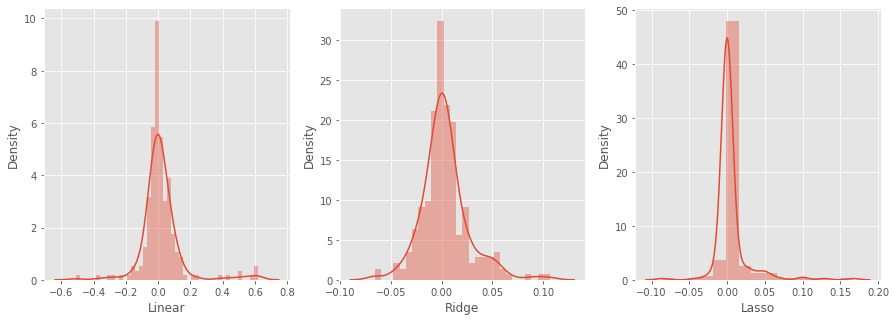

In [405]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.distplot(coeffs['Linear'], hist=True)
plt.subplot(1, 3, 2)
sns.distplot(coeffs['Ridge'], hist=True)
plt.subplot(1, 3, 3)
sns.distplot(coeffs['Lasso'], hist=True)
plt.show()

## Observations
- Linear regression has wide coefficients with very less than 10 features near zero.
- Ridge has close 25 features near zero. coefficients range is also narrower.
- Lasso has close 50 features near zero. coefficients range is also narrowest.

## Conclusion
We will choose to apply Lasso regression because: 
- It has only 69 features.  
    - This will make it easy to explain and interpret. 
    - This also makes the model more robust. 
- Adjusted R2-square is comparable to ridge. But ridge uses 228 features. So ridge model is more complex than Lasso. 
- Linear regression is overfitting – Adjusted R2-sqaured are 0.95 (train) and 0.84 (test).

### Top 10 most significant predictors

In [406]:
coeffs['LassoAbs'] = coeffs['Linear'].abs()
coeffs.sort_values(['LassoAbs'], ascending=False, inplace=True)
coeffs = coeffs.drop(['LassoAbs'], axis=1)
pd.DataFrame(columns=['Linear'], data=coeffs['Linear'], index=coeffs.index).head(10)

,Linear
MSZoning_RH,0.6193
MSZoning_RL,0.6123
MSZoning_FV,0.6083
MSZoning_RM,0.5764
RoofStyle_Shed,0.5151
RoofMatl_Membran,0.5132
Electrical_Mix,-0.5115
BsmtCond_Po,0.4392
RoofMatl_Metal,0.3849
LandSlope_Sev,-0.3663


In [407]:
coeffs['LassoAbs'] = coeffs['Lasso'].abs()
coeffs.sort_values(['LassoAbs'], ascending=False, inplace=True)
coeffs = coeffs.drop(['LassoAbs'], axis=1)
pd.DataFrame(columns=['Lasso'], data=coeffs['Lasso'], index=coeffs.index).head(10)

,Lasso
GrLivArea,0.1668
OverallQual,0.1284
SaleType_New,0.1013
Neighborhood_Crawfor,0.0989
Age,-0.0858
Neighborhood_Somerst,0.0697
MSZoning_RL,0.0609
SaleCondition_Normal,0.0520
BsmtFinSF1,0.0520
TotalBsmtSF,0.0520


In [408]:
coeffs['LassoAbs'] = coeffs['Ridge'].abs()
coeffs.sort_values(['LassoAbs'], ascending=False, inplace=True)
coeffs = coeffs.drop(['LassoAbs'], axis=1)
pd.DataFrame(columns=['Ridge'], data=coeffs['Ridge'], index=coeffs.index).head(10)

,Ridge
OverallQual,0.1070
GrLivArea,0.0967
Neighborhood_Crawfor,0.0864
MSZoning_RL,0.0684
Neighborhood_IDOTRR,-0.0661
Age,-0.0652
SaleCondition_Normal,0.0608
CentralAir_Y,0.0581
Neighborhood_StoneBr,0.0563
TotalBsmtSF,0.0532


### Multiply aplha by 2 and check effect

In [409]:
ridge_mdl1 = Ridge(alpha=ridge_best*2)
ridge_mdl1.fit(X_train, y_train)
lasso_mdl1 = Lasso(alpha=lasso_best*2)
lasso_mdl1.fit(X_train, y_train)

r_r2_train1, r_r2_test1, r_pred1, r_test_pred1 = print_results(ridge_mdl1, X_train, y_train, X_test, y_test, 0)
ls_r2_train1, ls_r2_test1, ls_pred1, ls_test_pred1 = print_results(lasso_mdl1, X_train, y_train, X_test, y_test, 0)
print(f'Ridge: {r_r2_train1}, {r_r2_test1} {list(ridge_mdl1.coef_).count(0.)}')
print(f'Lasso: {ls_r2_train1}, {ls_r2_test1} {X_train.shape[1] - list(lasso_mdl.coef_).count(0.)}')

Ridge: [0.9288179107402995, 0.010445330600064529, 0.072483758173444], [0.9028819905791418, 0.013275758516992205, 0.07836886686073972] 2
Lasso: [0.9143146826428361, 0.01257354872096641, 0.079320809321088], [0.8931622836917156, 0.014604415089165542, 0.08146534897002386] 69


In [410]:
# alphas = np.logspace(-10, 5, 20)
nfeatsLassoM2 = X_train.shape[1] - list(lasso_mdl1.coef_).count(0.)
nfeatsRidgeM2 = X_train.shape[1] - sum(1 for x in list(ridge_mdl1.coef_) if abs(x) == 0.000)
cdf = create_df_compare(['Linear', 'Ridge', 'm2Ridge', 'Lasso', 'm2Lasso'],  
                   [['-', nfeats] + r2_train + r2_test, 
                   [ridge_best, nfeatsRidge] + r_r2_train + r_r2_test, 
                   [ridge_best*2, nfeatsRidgeM2] + r_r2_train1 + r_r2_test1, 
                   [lasso_best, nfeatsLasso] + ls_r2_train + ls_r2_test,
                   [lasso_best*2, nfeatsLassoM2] + ls_r2_train1 + ls_r2_test1
                  ])
cdf

Label: Linear
Label: Ridge
Label: m2Ridge
Label: Lasso
Label: m2Lasso


,alpha,features,r2_train,r2_test,mse_train,mse_test,mae_train,mae_test,mse_test_to_train
Linear,-,230,0.9523,0.8415,0.0070,0.0217,0.0612,0.0920,3.0977
Ridge,15.0000,228,0.9340,0.9034,0.0097,0.0132,0.0699,0.0780,1.3622
m2Ridge,30.0000,228,0.9288,0.9029,0.0104,0.0133,0.0725,0.0784,1.2710
Lasso,0.0010,69,0.9237,0.9004,0.0112,0.0136,0.0748,0.0782,1.2156
m2Lasso,0.0020,49,0.9143,0.8932,0.0126,0.0146,0.0793,0.0815,1.1615


In [411]:
coeffs['m2Ridge'] = ridge_mdl1.coef_
coeffs['m2Lasso'] = lasso_mdl1.coef_

In [412]:
coeffs['LassoAbs'] = coeffs['m2Ridge'].abs()
coeffs.sort_values(['LassoAbs'], ascending=False, inplace=True)
coeffs = coeffs.drop(['LassoAbs'], axis=1)
pd.DataFrame(columns=['m2Ridge'], data=coeffs['m2Ridge'], index=coeffs.index).head(10)

,m2Ridge
MSZoning_RL,0.1073
SaleType_New,0.0904
KitchenQual_Gd,0.0652
Neighborhood_Edwards,-0.0582
TotalBsmtSF,0.0540
MasVnrType_None,0.0499
Condition2_RRAe,0.0499
HeatingQC_TA,0.0493
HeatingQC_Gd,-0.0481
Neighborhood_Somerst,0.0468


In [413]:
coeffs['LassoAbs'] = coeffs['m2Lasso'].abs()
coeffs.sort_values(['LassoAbs'], ascending=False, inplace=True)
coeffs = coeffs.drop(['LassoAbs'], axis=1)
pd.DataFrame(columns=['m2Lasso'], data=coeffs['m2Lasso'], index=coeffs.index).head(10)

,m2Lasso
SaleType_New,0.1631
MSZoning_RL,0.1412
Neighborhood_Edwards,-0.0941
3SsnPorch,0.0740
KitchenQual_Gd,0.0647
HeatingQC_TA,0.0554
SaleCondition_Normal,0.0551
TotalBsmtSF,0.0545
WoodDeckSF,0.0513
Neighborhood_IDOTRR,0.0450


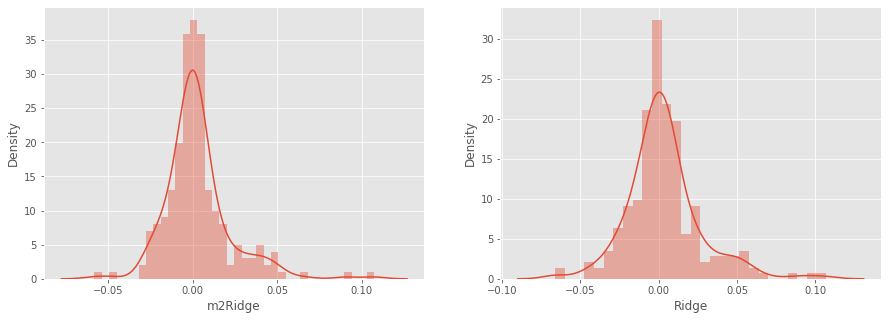

In [414]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(coeffs['m2Ridge'], hist=True)
plt.subplot(1, 2, 2)
sns.distplot(coeffs['Ridge'], hist=True)
plt.show()

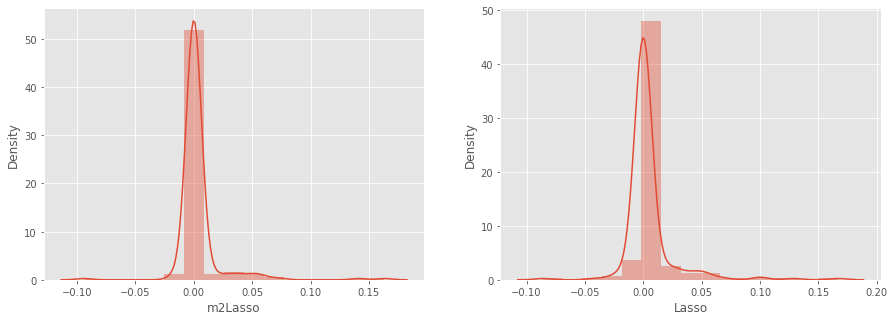

In [415]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(coeffs['m2Lasso'], hist=True)
plt.subplot(1, 2, 2)
sns.distplot(coeffs['Lasso'], hist=True)
plt.show()

### Check Residuals Lasso

Mean of resuduals 1044.6838
Stdev of resuduals 20438.1273


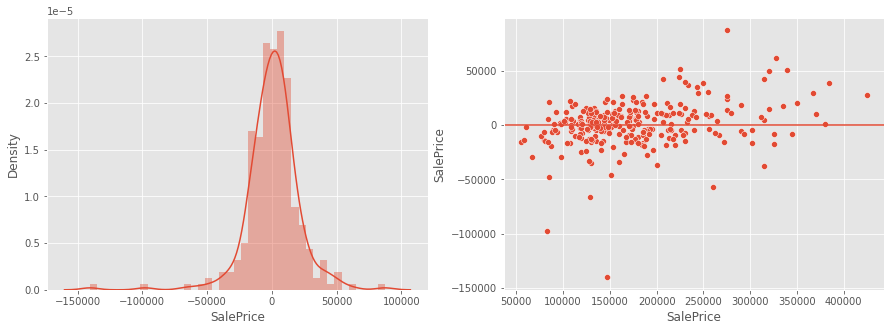

In [416]:
check_error_distribution(y_test, ls_test_pred1)

### Check Residuals Ridge

Mean of resuduals 619.0132
Stdev of resuduals 19127.8540


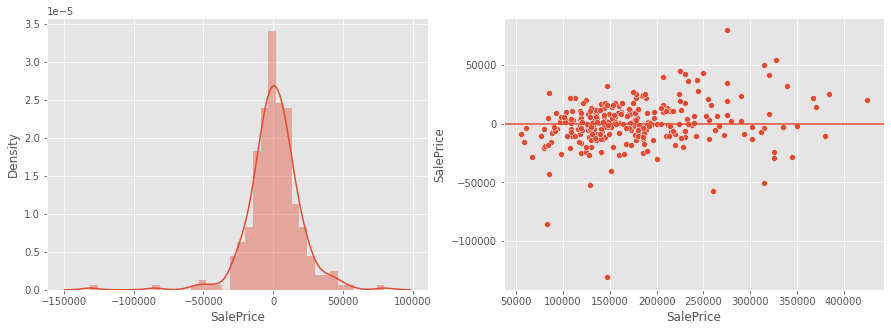

In [417]:
check_error_distribution(y_test, r_test_pred1)

### Drop top five features in lasso

In [418]:
coeffs['LassoAbs'] = coeffs['Lasso'].abs()
coeffs.sort_values(['LassoAbs'], ascending=False, inplace=True)
top_five = list(coeffs['Lasso'][0:5].index)
print(f'Dropping: {top_five}')
X_train_drp = X_train.drop(top_five, axis=1)
X_test_drp = X_test.drop(top_five, axis=1)
X_drp = X.drop(top_five, axis=1)

Dropping: ['GrLivArea', 'OverallQual', 'SaleType_New', 'Neighborhood_Crawfor', 'Age']


In [419]:
# params = {'alpha': [0.0001, .0002, .0004, .0008, 0.001, 0.0012, .0015, .0018, 0.002, .0022, .0025, 0.005, .01]}
# skf_gen = StratifiedKFold(5)
# lmdl_drp = GridSearchCV(Lasso(), param_grid=params, cv=5, scoring= 'r2',
#                     return_train_score=True, verbose=2)
# lmdl_drp.fit(X_drp, y)

In [420]:
# get_gridcv_results(lmdl_drp)

In [421]:
# lasso_mdl_drp = Lasso(alpha=lasso_best)
a_drop = lasso_best
lasso_mdl_drp = Lasso(alpha=a_drop)
lasso_mdl_drp.fit(X_train_drp, y_train)

ls_r2_train_drp, ls_r2_test_drp, ls_pred_drp, ls_test_pred_drp = print_results(
    lasso_mdl_drp, X_train_drp, y_train, X_test_drp, y_test, 0)

nfeatsLassoDrop = X_train.shape[1] - list(lasso_mdl_drp.coef_).count(0.)
cdfdrp = create_df_compare(['Linear', 'Ridge', 'Lasso', 'LassoDrop'], 
                  [['-', nfeats] + r2_train + r2_test,  
                   [ridge_best, nfeatsRidge] + r_r2_train + r_r2_test, 
                   [lasso_best, nfeatsLasso] + ls_r2_train + ls_r2_test,
                   [a_drop, nfeatsLassoDrop] + ls_r2_train_drp + ls_r2_test_drp 
                  ])
cdfdrp

Label: Linear
Label: Ridge
Label: Lasso
Label: LassoDrop


,alpha,features,r2_train,r2_test,mse_train,mse_test,mae_train,mae_test,mse_test_to_train
Linear,-,230,0.9523,0.8415,0.0070,0.0217,0.0612,0.0920,3.0977
Ridge,15.0000,228,0.9340,0.9034,0.0097,0.0132,0.0699,0.0780,1.3622
Lasso,0.0010,69,0.9237,0.9004,0.0112,0.0136,0.0748,0.0782,1.2156
LassoDrop,0.0010,82,0.9114,0.8868,0.0130,0.0155,0.0811,0.0857,1.1901


In [422]:
coeffsDropped = pd.DataFrame(index=X_train_drp.columns)
coeffsDropped['LassoDropped'] = lasso_mdl_drp.coef_
coeffsDropped['LassoDroppedAbs'] = coeffsDropped['LassoDropped'].abs()
coeffsDropped.sort_values(['LassoDropped'], ascending=False, inplace=True)
coeffsDropped = coeffsDropped.drop(['LassoDroppedAbs'], axis=1)
coeffsDropped.head(10)

,LassoDropped
2ndFlrSF,0.1858
1stFlrSF,0.1456
SaleCondition_Partial,0.1033
Neighborhood_Somerst,0.0949
Functional_Typ,0.0776
Neighborhood_StoneBr,0.0756
CentralAir_Y,0.0697
TotalBsmtSF,0.0697
Foundation_PConc,0.0589
SaleCondition_Normal,0.0583


Mean of resuduals 176.3636
Stdev of resuduals 20949.5781


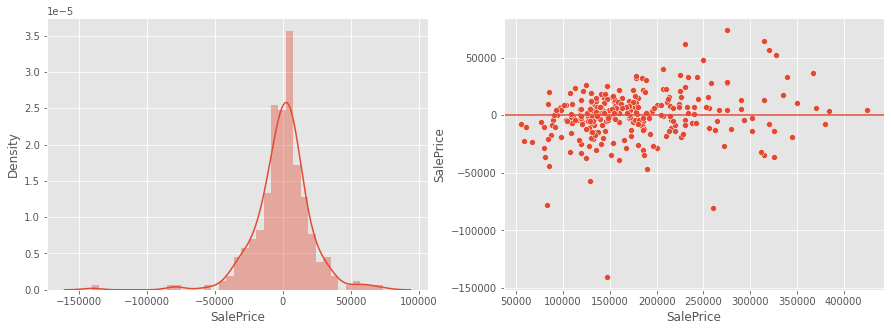

In [423]:
check_error_distribution(y_test, ls_test_pred_drp)

### Bonus Try RFE 

In [424]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor 
rfe = RFE(estimator=LinearRegression(), n_features_to_select=100,verbose=0)
rfe.fit(X_train, y_train)

rfecol = X_train.columns[rfe.support_]
X_train_rfe = X_train[rfecol]
X_test_rfe = X_test[rfecol]
print(X_train_rfe.shape, X_test_rfe.shape)

lmrfe = LinearRegression()
lmrfe.fit(X_train_rfe,y_train)
r2_train_rfe, r2_test_rfe, y_pred_rfe, y_test_pred_rfe = print_results(lmrfe, X_train_rfe, y_train, X_test_rfe, y_test, 0)
coefrfe = pd.DataFrame(index=X_train_rfe.columns)
coefrfe['lmrfe'] = lmrfe.coef_
des = coefrfe['lmrfe'].describe(percentiles=[.05, .1, .25, .5, .75, .9, .95])
print(des)
print(f'R2 train: {r2_train_rfe}, R2 test: {r2_test_rfe}')

(1141, 100) (286, 100)
count                  100.0000
mean                     0.0416
std        537,392,567,016.6252
min     -1,873,967,328,751.4473
5%         -24,906,272,894.1639
10%                     -0.1699
25%                     -0.0457
50%                      0.0288
75%                      0.1034
90%                      0.2909
95%         24,906,272,894.3835
max      1,873,967,328,751.6267
Name: lmrfe, dtype: float64
R2 train: [0.9315591397809615, 0.010043079923272117, 0.07491788336331752], R2 test: [0.8362524060260278, 0.02238383517434465, 0.09605311973798242]


In [425]:
ridge_mdl_rfe = Ridge(alpha=ridge_best)
ridge_mdl_rfe.fit(X_train_rfe, y_train)
lasso_mdl_rfe = Lasso(alpha=lasso_best)
lasso_mdl_rfe.fit(X_train_rfe, y_train)

r_r2_train_rfe, r_r2_test_rfe, r_pred, r_test_pred = print_results(
    ridge_mdl_rfe, X_train_rfe, y_train, X_test_rfe, y_test, 0)
ls_r2_train_rfe, ls_r2_test_rfe, ls_pred, ls_test_pred = print_results(
    lasso_mdl_rfe, X_train_rfe, y_train, X_test_rfe, y_test, 0)

nfeatsLassoRfe = X_train_rfe.shape[1] - list(lasso_mdl_rfe.coef_).count(0.)
nfeatsRidgeRfe = X_train_rfe.shape[1] - sum(1 for x in list(ridge_mdl_rfe.coef_) if abs(x) == 0.000)
compdfrfe = create_df_compare(['LinearRfe', 'RidgeRfe', 'LassoRfe'], 
                           [['-', 100] + r2_train_rfe + r2_test_rfe, 
                            [ridge_best, nfeatsRidgeRfe] + r_r2_train_rfe + r_r2_test_rfe, 
                            [lasso_best, nfeatsLassoRfe] + ls_r2_train_rfe + ls_r2_test_rfe])
# compdfrfe = create_df_compare(['LinearRfe', 'RidgeRfe', 'LassoRfe'], 
#                   [r2_train_rfe + r2_test_rfe, r_r2_train_rfe + r_r2_test_rfe, 
#                    ls_r2_train_rfe + ls_r2_test_rfe
#                   ])
compdfrfe

Label: LinearRfe
Label: RidgeRfe
Label: LassoRfe


,alpha,features,r2_train,r2_test,mse_train,mse_test,mae_train,mae_test,mse_test_to_train
LinearRfe,-,100,0.9316,0.8363,0.0100,0.0224,0.0749,0.0961,2.2288
RidgeRfe,15.0000,100,0.9232,0.8991,0.0113,0.0138,0.0753,0.0798,1.2243
LassoRfe,0.0010,40,0.9154,0.8968,0.0124,0.0141,0.0797,0.0814,1.1362


## Observations
- Lasso is again the best because number of features get reduced to 40.
- Linear regression overfits with 100 features also - We need to reduce features further.

In [426]:
coeffsRfe = pd.DataFrame(index=X.columns)
coeffsRfe['Linear'] = lm.coef_
coeffsRfe['Ridge'] = ridge_mdl.coef_
coeffsRfe['Lasso'] = lasso_mdl.coef_
coeffsRfe.describe(percentiles=[.05, .1, .25, .5, .75, .9, .95])

,Linear,Ridge,Lasso
count,230.0000,230.0000,230.0000
mean,0.0175,0.0033,0.0046
std,0.1271,0.0236,0.0215
min,-0.5115,-0.0661,-0.0858
5%,-0.1086,-0.0294,-0.0092
10%,-0.0668,-0.0209,-0.0000
25%,-0.0299,-0.0083,0.0000
50%,0.0002,0.0007,-0.0000
75%,0.0465,0.0109,0.0000
90%,0.0942,0.0316,0.0186


In [427]:
coeffsRfe['LassoAbs'] = coeffsRfe['Linear'].abs()
coeffsRfe.sort_values(['LassoAbs'], ascending=False, inplace=True)
coeffsRfe = coeffsRfe.drop(['LassoAbs'], axis=1)
pd.DataFrame(columns=['Linear'], data=coeffsRfe['Linear'], index=coeffsRfe.index).head(10)

,Linear
MSZoning_RH,0.6193
MSZoning_RL,0.6123
MSZoning_FV,0.6083
MSZoning_RM,0.5764
RoofStyle_Shed,0.5151
RoofMatl_Membran,0.5132
Electrical_Mix,-0.5115
BsmtCond_Po,0.4392
RoofMatl_Metal,0.3849
LandSlope_Sev,-0.3663


In [428]:
coeffsRfe['LassoAbs'] = coeffsRfe['Lasso'].abs()
coeffsRfe.sort_values(['LassoAbs'], ascending=False, inplace=True)
coeffsRfe = coeffsRfe.drop(['LassoAbs'], axis=1)
pd.DataFrame(columns=['Lasso'], data=coeffsRfe['Lasso'], index=coeffsRfe.index).head(10)

,Lasso
GrLivArea,0.1668
OverallQual,0.1284
SaleType_New,0.1013
Neighborhood_Crawfor,0.0989
Age,-0.0858
Neighborhood_Somerst,0.0697
MSZoning_RL,0.0609
SaleCondition_Normal,0.0520
BsmtFinSF1,0.0520
TotalBsmtSF,0.0520


In [429]:
coeffsRfe['LassoAbs'] = coeffsRfe['Ridge'].abs()
coeffsRfe.sort_values(['LassoAbs'], ascending=False, inplace=True)
coeffsRfe = coeffsRfe.drop(['LassoAbs'], axis=1)
pd.DataFrame(columns=['Ridge'], data=coeffsRfe['Ridge'], index=coeffsRfe.index).head(10)

,Ridge
OverallQual,0.1070
GrLivArea,0.0967
Neighborhood_Crawfor,0.0864
MSZoning_RL,0.0684
Neighborhood_IDOTRR,-0.0661
Age,-0.0652
SaleCondition_Normal,0.0608
CentralAir_Y,0.0581
Neighborhood_StoneBr,0.0563
TotalBsmtSF,0.0532


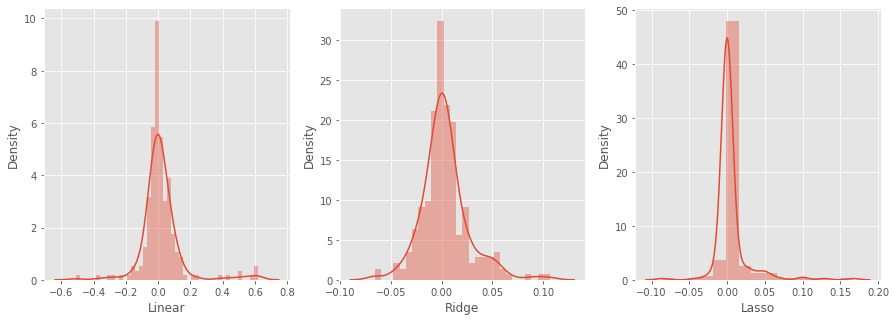

In [430]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.distplot(coeffsRfe['Linear'], hist=True)
plt.subplot(1, 3, 2)
sns.distplot(coeffsRfe['Ridge'], hist=True)
plt.subplot(1, 3, 3)
sns.distplot(coeffsRfe['Lasso'], hist=True)
plt.show()

## Observations
- Linear regression has wide coefficients with very less than 10 features near zero.
- Ridge has close 35 features near zero. coefficients range is also narrower.
- Lasso has close 50 features near zero. coefficients range is also narrowest.